### **数据背景：基于随机库合成了一批5UTR序列，测定其平均核糖体载量MRL**

### **1）阅读参考资料给出的数据来源原始论文，进行400字左右总结，重点解释原文中模型如何搭建(3分)**

* 这篇文章的研究背景是：5'非编码区 (UTR) 的序列对蛋白质翻译效率至关重要，且目前缺乏从 5' UTR 序列准确预测蛋白质表达的方法，限制了我们对基因组编码变异影响的理解和 5' UTR 的工程化改造。而他们创建了一个28万个基因序列的库，选了其中26万个作为训练数据，剩下的2万个作为测试数据，通过 CNN 训练数据，建立 5' UTR 序列与核糖体负载量之间的关系模型 (Optimus 5-Prime)和另一个多聚核糖体分布模型。并利用该模型设计新序列实现目标负载量，预测人类 5' UTR 变异对核糖体负载量的影响。
* 这篇文章中的模型搭建是通过 CNN 实现的，根据5' UTR序列预测翻译效率（MRL）。模型的输入数据是5' UTR序列，每条序列的长度为50个碱基，通过one-hot编码碱基转换为矩阵形式，最终输入矩阵形状调整后适配卷积神经网络的需求。模型包含多层一维卷积层，用于提取更深层次的序列特征，每层包括输入通道4，输出通道数为过滤器数量（120），卷积核大小8，激活函数ReLU，填充same。卷积操作后，数据通过ReLU进行激活，保证模型可以对复杂模式进行表达。在经过卷积层和池化层后，输出一个三维张量，使用Flatten操作将三维张量展平为二维张量，传入全连接层。第一层全连接层提取高维特征，输出隐藏层节点（80），最后一层全连接层输出最终预测值。为了防止过拟合，在卷积层和全连接层之间加入Dropout层。最后，模型输出一个标量，代表MRL的预测值。模型训练使用均方误差（MSE）作为损失函数，衡量预测值与真实值的差距，并使用Adam优化器进行训练。在多聚核糖体分布模型中，将输出层改为了 14 个线性输出，代表 14 个多聚核糖体组分。而文中的超参数是通过网格搜索优化选择的。

### **2）利用本次作业的附件数据集，自选一种合适的序列AI模型(CNN, RNN, LSTM, Transformer等)实现基于序列特征预测核糖体的任务。简要介绍模型（2分），用pytorch代码实现并训练（3分）**

**模型介绍**
* 本次作业选择使用卷积神经网络（CNN）模型来实现基于序列特征预测核糖体的任务。CNN是一种深度学习模型，特别适用于处理图像数据，但也可以应用于序列数据。CNN通过卷积层和池化层来提取序列中的局部特征，并通过全连接层来预测核糖体的负载量。
* 这里使用的模型先将序列中的碱基转换为矩阵，进行one-hot编码，转换为pytorch张量，然后通过卷积层和池化层提取局部的序列特征，最后通过全连接层输出预测结果。

In [5]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
print("Train Columns:", train.columns)
print("Test Columns:", test.columns)

Train Columns: Index(['seq', 'label'], dtype='object')
Test Columns: Index(['seq', 'label'], dtype='object')


In [7]:
print(train.head())
print(test.head())

                                                  seq     label
0  GTGTAAGGCTCTGGTGGGCACACGTCGGTTTGCAGTAATGACAGACACGT -1.740237
1  CTGTCACGAGCTCGCCTAGCGTTGACACTAAGAGTCAAAGAAAAATTAGA  1.074840
2  ACAAGTTACAAGGAGATCTCAAACGCAGGAGGTCACAAGGAAGAGCTTAC  0.793439
3  TCACCCGACCGCCAAGCCCGAACCTAACTCACGGGGGCCAACTCTCGGAG  0.328625
4  GGAGGGAAGCTACCTAAATCTCACTCCGAACTTGGTATATAACAATGATA  1.306698
                                                  seq     label
0  CCACTCGATTAACATGTTAACAACATACTCGTCCGGCCGATCAGCGGCTA -1.450717
1  CAAATCATGTGCAGCCCTGGCGACCGTACTGCGGTACAAGAAAGTATAGT -0.986874
2  GTTATACTAGAAGAAACTTGAGATTATGGAGCAGTCCGTCAAGGACGCGA -1.290934
3  CTTAGACAAAAACAACGCGCTTTCCAGTATGCGGAGCCTTGACGGTAAAC -1.160456
4  GTATCAAATCACGGCCAACCCGACGGAGTACCCCGCGTCGATGGTCCGCC -0.607953


In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
import scipy.stats as stats
import seaborn as sns
from sklearn import preprocessing
import random

# 设置随机种子
np.random.seed(1337)
torch.manual_seed(1337)

# 函数定义
def one_hot_encode(df, col='seq', seq_len=50):
    # 碱基转换
    nuc_d = {'a': [1, 0, 0, 0], 'c': [0, 1, 0, 0], 'g': [0, 0, 1, 0], 't': [0, 0, 0, 1], 'n': [0, 0, 0, 0]}
    
    # 创建一个空的numpy数组来存储编码后的向量
    vectors = np.empty([len(df), seq_len, 4])
    
    # 迭代UTR并编码
    for i, seq in enumerate(df[col].str[:seq_len]): 
        seq = seq.lower()
        vectors[i] = np.array([nuc_d[x] for x in seq])
    
    return vectors

# 定义模型
class PolyProfileModel(nn.Module):
    def __init__(self, inp_len=50, nbr_filters=120, filter_len=8, nodes=80, dropout1=0, dropout2=0, dropout3=0.1, layers=3):
        super(PolyProfileModel, self).__init__()
        
        self.layers = layers
        self.conv1 = nn.Conv1d(4, nbr_filters, filter_len, padding='same')  # 输入通道为 4
        self.conv2 = nn.Conv1d(nbr_filters, nbr_filters, filter_len, padding='same')
        self.conv3 = nn.Conv1d(nbr_filters, nbr_filters, filter_len, padding='same')
        
        self.dropout1 = nn.Dropout(dropout1)
        self.dropout2 = nn.Dropout(dropout2)
        self.dropout3 = nn.Dropout(dropout3)
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(nbr_filters * inp_len, nodes)
        self.fc2 = nn.Linear(nodes, 1)  # 输出通道为 1，适应 label 的维度

        self.relu = nn.ReLU()

    def forward(self, x):
        # 调整维度为 (batch_size, channels, sequence_length)
        x = x.permute(0, 2, 1)
        
        x = self.relu(self.conv1(x))
        if self.layers > 1:
            x = self.relu(self.conv2(x))
            x = self.dropout1(x)
        if self.layers > 2:
            x = self.relu(self.conv3(x))
            x = self.dropout2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout3(x)
        x = self.fc2(x)
        return x

# 导入数据集
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

# 准备训练和测试集 One-hot 编码
seq_train = one_hot_encode(train, col='seq', seq_len=50)
seq_test = one_hot_encode(test, col='seq', seq_len=50)

# 提取 label 列作为目标值
y_train = train['label'].values
y_test = test['label'].values

# 转换为 PyTorch 张量
X_train = torch.tensor(seq_train, dtype=torch.float32)
X_test = torch.tensor(seq_test, dtype=torch.float32)

y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # 添加一个维度
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)    # 添加一个维度

y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# 模型参数设置
model = PolyProfileModel(inp_len=50, nbr_filters=120, filter_len=8, nodes=80, dropout1=0, dropout2=0, dropout3=0.1, layers=3)

# 建立损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 记录训练过程
history = {"train_loss": [], "val_loss": [], "train_r2": [], "val_r2": []}

def calculate_r2(outputs, labels):
    ss_total = torch.sum((labels - torch.mean(labels)) ** 2)
    ss_residual = torch.sum((labels - outputs) ** 2)
    r2 = 1 - ss_residual / ss_total
    return r2.item()

# 模型训练和验证
num_epochs = 20 
batch_size = 128

train_data = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

test_data = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

for epoch in range(num_epochs): 
    model.train()
    train_loss, train_r2 = 0.0, 0.0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_r2 += calculate_r2(outputs, labels)

    train_loss /= len(train_loader)
    train_r2 /= len(train_loader)
    
    # 验证阶段
    model.eval()
    val_loss, val_r2 = 0.0, 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_r2 += calculate_r2(outputs, labels)

    val_loss /= len(test_loader)
    val_r2 /= len(test_loader)

    # 记录训练和验证结果
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_r2"].append(train_r2)
    history["val_r2"].append(val_r2)

    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Train R² = {train_r2:.4f}, "
          f"Val Loss = {val_loss:.4f}, Val R² = {val_r2:.4f}")




C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16320\2314180254.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16320\2314180254.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


Epoch 1: Train Loss = 0.2321, Train R² = 0.7656, Val Loss = 0.3282, Val R² = 0.6476
Epoch 2: Train Loss = 0.1399, Train R² = 0.8588, Val Loss = 0.4043, Val R² = 0.5657
Epoch 3: Train Loss = 0.1302, Train R² = 0.8686, Val Loss = 0.4117, Val R² = 0.5576
Epoch 4: Train Loss = 0.1245, Train R² = 0.8741, Val Loss = 0.3876, Val R² = 0.5835
Epoch 5: Train Loss = 0.1201, Train R² = 0.8787, Val Loss = 0.3433, Val R² = 0.6314
Epoch 6: Train Loss = 0.1169, Train R² = 0.8819, Val Loss = 0.3251, Val R² = 0.6509
Epoch 7: Train Loss = 0.1138, Train R² = 0.8850, Val Loss = 0.3220, Val R² = 0.6546
Epoch 8: Train Loss = 0.1111, Train R² = 0.8878, Val Loss = 0.2942, Val R² = 0.6844
Epoch 9: Train Loss = 0.1081, Train R² = 0.8909, Val Loss = 0.2398, Val R² = 0.7426
Epoch 10: Train Loss = 0.1059, Train R² = 0.8932, Val Loss = 0.2882, Val R² = 0.6906
Epoch 11: Train Loss = 0.1024, Train R² = 0.8964, Val Loss = 0.3066, Val R² = 0.6708
Epoch 12: Train Loss = 0.1006, Train R² = 0.8983, Val Loss = 0.3103, Val R

### **3）合理评估模型（2分）** 

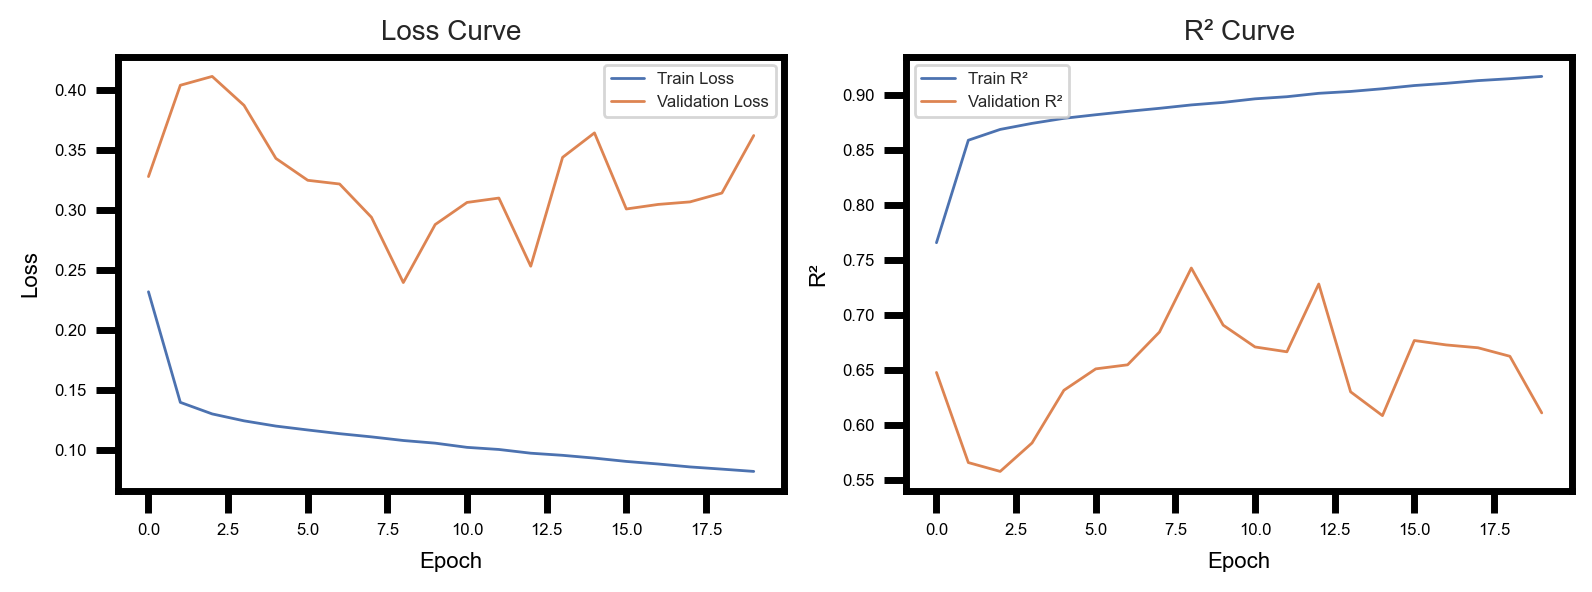

In [39]:
import matplotlib.pyplot as plt

plt.rcParams.update({
    'font.size': 8,         
    'axes.titlesize': 10,   
    'axes.labelsize': 8,    
    'xtick.labelsize': 6,   
    'ytick.labelsize': 6,   
    'legend.fontsize': 6    
})


fig, axes = plt.subplots(1, 2, figsize=(8, 3))  

# Loss Curve
axes[0].plot(history["train_loss"], label="Train Loss", linewidth=1)
axes[0].plot(history["val_loss"], label="Validation Loss", linewidth=1)
axes[0].legend()
axes[0].set_title("Loss Curve")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")

# R² Curve
axes[1].plot(history["train_r2"], label="Train R²", linewidth=1)
axes[1].plot(history["val_r2"], label="Validation R²", linewidth=1)
axes[1].legend()
axes[1].set_title("R² Curve")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("R²")

plt.tight_layout()
plt.show()


In [45]:
from sklearn.metrics import mean_squared_error

# 计算 MSE 和 RMSE
mse = mean_squared_error(y_test, predictions)
rmse = mse ** 0.5

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")


Mean Squared Error (MSE): 0.3624
Root Mean Squared Error (RMSE): 0.6020


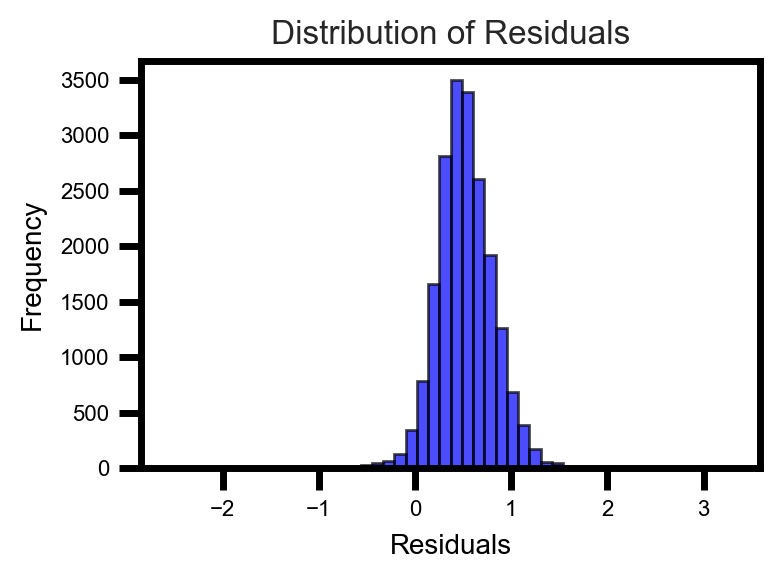

In [43]:
# 计算残差
residuals = y_test - predictions

# 绘制残差分布
plt.rcParams.update({
    'font.size': 10,         
    'axes.titlesize': 12,    
    'axes.labelsize': 10,    
    'xtick.labelsize': 8,    
    'ytick.labelsize': 8,    
})
plt.figure(figsize=(4, 3))
plt.hist(residuals, bins=50, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals")
plt.show()


In [31]:
from scipy.stats import pearsonr, spearmanr

# 计算 Pearson 和 Spearman 相关系数
pearson_corr, _ = pearsonr(y_test, predictions)
spearman_corr, _ = spearmanr(y_test, predictions)

print(f"Pearson Correlation: {pearson_corr:.4f}")
print(f"Spearman Correlation: {spearman_corr:.4f}")

Pearson Correlation: 0.9620
Spearman Correlation: 0.9443


**模型评估**

由损失曲线和R²曲线可以看出，模型在训练集上的表现较好，但在验证集上经过学习过程其损失和R²都未得到明显改进，说明模型泛化能力不佳。而该模型的残差分布表现良好，接近正态分布，说明模型整体准确性较高且无明显偏差，但可以针对尾部误差做进一步优化。此外，Pearson和Spearman都接近1，说明模型在拟合真实值时表现非常好，无论是线性关系还是排序关系都很强，可以认为模型效果较为理想。

**参考资料：** 
1. 原始论文:https://www.nature.com/articles/s41587-019-0164-5 
2. 数据处理流程:https://github.com/pjsample/human_5utr_modeling